在 Agent Supervisor 中引入了单个 supervisor 节点协调多个 worker 节点间的路由  
但是如果单个节点过于复杂或者 worker 节点太多时会使 supervisor 节点成为瓶颈  
因此这里使用分层结构来解决这个问题

In [1]:
import { config } from "dotenv"

config({
  path: ".env.local",
})

console.log(process.env.BASE_URL)


[dotenv@17.0.1] injecting env (8) from .env.local – [tip] encrypt with dotenvx: https://dotenvx.com
https://dashscope.aliyuncs.com/compatible-mode/v1


In [2]:
import { TavilySearch } from "@langchain/tavily"
import { CheerioWebBaseLoader } from "@langchain/community/document_loaders/web/cheerio"
import { tool } from "@langchain/core/tools"
import { z } from "zod"

const tavilyTool = new TavilySearch()

// @ts-ignore
const scrapeWebpage = tool(
  async (input) => {
    const loader = new CheerioWebBaseLoader(input.url)
    const docs = await loader.load()
    const formattedDocs = docs.map(
      (doc) =>
        `<Document name="${doc.metadata?.title}">\n${doc.pageContent}\n</Document>`
    )
    return formattedDocs.join("\n\n")
  },
  {
    name: "scrape_webpage",
    description: "Scrape the contents of a webpage.",
    schema: z.object({
      url: z.string(),
    }),
  }
)


In [3]:
import "tsx"
import { createCanvas } from "canvas"
import * as d3 from "d3"
import * as tslab from "tslab"
import * as fs from "fs/promises"
import * as path from "path"
import { tool } from "@langchain/core/tools"
import { z } from "zod"

const WORKING_DIRECTORY = "./temp"
await fs.mkdir(WORKING_DIRECTORY, { recursive: true })

const createOutlineTool = tool(
  async ({ points, file_name }) => {
    const filePath = path.join(WORKING_DIRECTORY, file_name)
    const data = points
      .map((point, index) => `${index + 1}. ${point}\n`)
      .join("")
    await fs.writeFile(filePath, data)
    return `Outline saved to ${file_name}`
  },
  {
    name: "create_outline",
    description: "Create and save on outline.",
    schema: z.object({
      points: z
        .array(z.string())
        .nonempty("List of main points or sections must not be empty"),
      file_name: z.string(),
    }),
  }
)

const readDocumentTool = tool(
  async ({ file_name, start, end }) => {
    const filePath = path.join(WORKING_DIRECTORY, file_name)
    const data = await fs.readFile(filePath, "utf-8")
    const lines = data.split("\n")
    return lines.slice(start ?? 0, end).join("\n")
  },
  {
    name: "read_document",
    description: "Read the specified document.",
    schema: z.object({
      file_name: z.string(),
      start: z.number().optional(),
      end: z.number().optional(),
    }),
  }
)

const writeDocumentTool = tool(
  async ({ content, file_name }) => {
    const filePath = path.join(WORKING_DIRECTORY, file_name)
    await fs.writeFile(filePath, content)
    return `Document saved to ${file_name}`
  },
  {
    name: "write_document",
    description: "Create and save a text document.",
    schema: z.object({
      content: z.string(),
      file_name: z.string(),
    }),
  }
)

const editDocumentTool = tool(
  async ({ file_name, inserts }) => {
    const filePath = path.join(WORKING_DIRECTORY, file_name)
    const data = await fs.readFile(filePath, "utf-8")
    let lines = data.split("\n")

    const sortedInserts = Object.entries(inserts).sort(
      ([a], [b]) => parseInt(a) - parseInt(b)
    )

    for (const [line_number_str, text] of sortedInserts) {
      const line_number = parseInt(line_number_str)
      if (1 <= line_number && line_number <= lines.length + 1) {
        lines.splice(line_number - 1, 0, text)
      } else {
        return `Error: Line number ${line_number} is out of range`
      }
    }

    await fs.writeFile(filePath, lines.join("\n"))
    return `Document edited and saved to ${file_name}`
  },
  {
    name: "edit_document",
    description: "Edit a document by inserting text at specific line numbers.",
    schema: z.object({
      file_name: z.string(),
      inserts: z.record(z.number(), z.string()),
    }),
  }
)

const chartTool = tool(
  async ({ data }) => {
    const width = 500
    const height = 500
    const margin = { top: 20, right: 30, bottom: 30, left: 40 }

    const canvas = createCanvas(width, height)
    const ctx = canvas.getContext("2d")

    const x = d3
      .scaleBand()
      .domain(data.map((d) => d.label))
      .range([margin.left, width - margin.right])
      .padding(0.1)

    const y = d3
      .scaleLinear()
      .domain([0, d3.max(data, (d) => d.value) ?? 0])
      .nice()
      .range([height - margin.bottom, margin.top])

    const colorPalette = [
      "#e6194B",
      "#3cb44b",
      "#ffe119",
      "#4363d8",
      "#f58231",
      "#911eb4",
      "#42d4f4",
      "#f032e6",
      "#bfef45",
      "#fabebe",
    ]

    for (let i = 0; i < data.length; i++) {
      const d = data[i]
      ctx.fillStyle = colorPalette[i % colorPalette.length]
      ctx.fillRect(
        x(d.label) ?? 0,
        y(d.value),
        x.bandwidth(),
        height - margin.bottom - y(d.value)
      )
    }

    ctx.beginPath()
    ctx.strokeStyle = "black"
    ctx.moveTo(margin.left, height - margin.bottom)
    ctx.lineTo(width - margin.right, height - margin.bottom)
    ctx.stroke()

    ctx.textAlign = "center"
    ctx.textBaseline = "top"
    x.domain().forEach((d) => {
      const xCoord = (x(d) ?? 0) + x.bandwidth() / 2
      ctx.fillText(d, xCoord, height - margin.bottom + 6)
    })

    ctx.beginPath()
    ctx.moveTo(margin.left, height - margin.top)
    ctx.lineTo(margin.left, height - margin.bottom)
    ctx.stroke()

    ctx.textAlign = "right"
    ctx.textBaseline = "middle"
    const ticks = y.ticks()
    ticks.forEach((d) => {
      const yCoord = y(d)
      ctx.moveTo(margin.left, yCoord)
      ctx.lineTo(margin.left - 6, yCoord)
      ctx.stroke()
      ctx.fillText(d.toString(), margin.left - 8, yCoord)
    })

    tslab.display.png(canvas.toBuffer())
    return "Chart has been generated and displayed to the user!"
  },
  {
    name: "generate_bar_chart",
    description:
      "Generates a bar chart from an array of data points using D3.js and displays it for the user.",
    schema: z.object({
      data: z
        .object({
          label: z.string(),
          value: z.number(),
        })
        .array(),
    }),
  }
)


In [4]:
await writeDocumentTool.invoke({
  content: "Hello from LangGraph!",
  file_name: "hello.txt",
})


Document saved to hello.txt


In [5]:
await readDocumentTool.invoke({ file_name: "hello.txt" })


Hello from LangGraph!


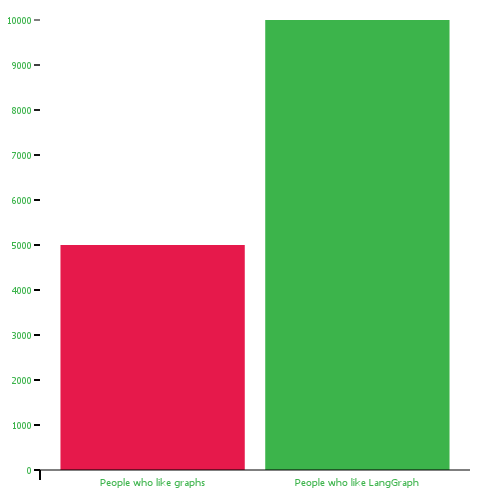

Chart has been generated and displayed to the user!


In [6]:
await chartTool.invoke({
  data: [
    { label: "People who like graphs", value: 5000 },
    { label: "People who like LangGraph", value: 10000 },
  ],
})


## Helper Utilities

1. 创建工作代理
2. 为子图创建一个主管

In [7]:
import { z } from "zod"
import {
  HumanMessage,
  BaseMessage,
  SystemMessage,
} from "@langchain/core/messages"
import {
  ChatPromptTemplate,
  MessagesPlaceholder,
} from "@langchain/core/prompts"
import { JsonOutputToolsParser } from "@langchain/core/output_parsers/openai_tools"
import { ChatOpenAI } from "@langchain/openai"
import { Runnable } from "@langchain/core/runnables"
import { StructuredToolInterface } from "@langchain/core/tools"
import { MessagesAnnotation } from "@langchain/langgraph"

const agentStateModifier = (
  systemPrompt: string,
  tools: StructuredToolInterface[],
  teamMembers: string[]
): ((state: typeof MessagesAnnotation.State) => BaseMessage[]) => {
  const toolNames = tools.map((t) => t.name).join(", ")
  const systemMsgStart = new SystemMessage(
    systemPrompt +
      "\nWork autonomously according to your specialty, using the tools available to you." +
      " Do not ask for clarification." +
      " Your other team members (and other teams) will collaborate with you with their own specialties." +
      ` You are chosen for a reason! You are one of the following team members: ${teamMembers.join(
        ", "
      )}.`
  )
  const systemMsgEnd = new SystemMessage(
    `Supervisor instructions: ${systemPrompt}\n` +
      `Remember, you individually can only use these tools: ${toolNames}` +
      "\n\nEnd if you have already completed the requested task. Communicate the work completed."
  )

  return (state: typeof MessagesAnnotation.State): any[] => [
    systemMsgStart,
    ...state.messages,
    systemMsgEnd,
  ]
}

async function runAgentNode(params: {
  state: any
  agent: Runnable
  name: string
}) {
  const { state, agent, name } = params
  const result = await agent.invoke({
    messages: state.messages,
  })
  const lastMessage = result.messages[result.messages.length - 1]
  return {
    messages: [new HumanMessage({ content: lastMessage.content, name })],
  }
}

async function createTeamSupervisor(
  llm: ChatOpenAI,
  systemPrompt: string,
  members: string[]
): Promise<Runnable> {
  const options = ["FINISH", ...members]
  const routeTool = {
    name: "route",
    description: "Select the next role.",
    schema: z.object({
      reasoning: z.string(),
      next: z.enum(["FINISH", ...members]),
      instructions: z
        .string()
        .describe(
          "The specific instructions of the sub-task the next role should accomplish."
        ),
    }),
  }
  let prompt = ChatPromptTemplate.fromMessages([
    ["system", systemPrompt],
    new MessagesPlaceholder("messages"),
    [
      "system",
      "Given the conversation above, who should act next? Or should we FINISH? Select one of: {options}",
    ],
  ])

  prompt = await prompt.partial({
    options: options.join(", "),
    team_members: members.join(", "),
  })

  const supervisor = prompt
    .pipe(
      llm.bindTools([routeTool], {
        tool_choice: "route",
      })
    )
    .pipe(new JsonOutputToolsParser())
    .pipe((x) => ({
      next: (x[0] as any).args.next,
      instructions: (x[0] as any).args.instructions,
    }))

  return supervisor
}


In [8]:
import { BaseMessage } from "@langchain/core/messages"
import { Annotation } from "@langchain/langgraph"
import { createReactAgent } from "@langchain/langgraph/prebuilt"

const ResearchTeamState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
  }),
  team_members: Annotation<string[]>({
    reducer: (x, y) => x.concat(y),
  }),
  next: Annotation<string>({
    reducer: (x, y) => y ?? x,
    default: () => "supervisor",
  }),
  instructions: Annotation<string>({
    reducer: (x, y) => y ?? x,
    default: () => "Solve the human's question.",
  }),
})

const llm = new ChatOpenAI({
  model: "qwen-plus-2025-01-25",
  apiKey: process.env.Tongyi_API_KEY,
  configuration: {
    baseURL: process.env.BASE_URL,
  },
})

const searchNode = (state: typeof ResearchTeamState.State) => {
  const stateModifier = agentStateModifier(
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
    [tavilyTool],
    state.team_members ?? ["Search"]
  )
  const searchAgent = createReactAgent({
    llm,
    tools: [tavilyTool],
    stateModifier,
  })
  return runAgentNode({ state, agent: searchAgent, name: "Search" })
}

const researchNode = (state: typeof ResearchTeamState.State) => {
  const stateModifier = agentStateModifier(
    "You are a research assistant who can scrape specified urls for more detailed information using the scrapeWebpage function.",
    [scrapeWebpage],
    state.team_members ?? ["WebScraper"]
  )
  const researchAgent = createReactAgent({
    llm,
    tools: [scrapeWebpage],
    stateModifier,
  })
  return runAgentNode({ state, agent: researchAgent, name: "WebScraper" })
}

const supervisorAgent = await createTeamSupervisor(
  llm,
  "You are a supervisor tasked with managing a conversation between the" +
    " following workers:  {team_members}. Given the following user request," +
    " respond with the worker to act next. Each worker will perform a" +
    " task and respond with their results and status. When finished," +
    " respond with FINISH.\n\n" +
    " Select strategically to minimize the number of steps taken.",
  ["Search", "WebScraper"]
)


In [9]:
import { END, START, StateGraph } from "@langchain/langgraph"
import { RunnableLambda } from "@langchain/core/runnables"

const researchGraph = new StateGraph(ResearchTeamState)
  .addNode("Search", searchNode)
  .addNode("supervisor", supervisorAgent)
  .addNode("WebScraper", researchNode)
  // Define the control flow
  .addEdge("Search", "supervisor")
  .addEdge("WebScraper", "supervisor")
  .addConditionalEdges("supervisor", (x) => x.next, {
    Search: "Search",
    WebScraper: "WebScraper",
    FINISH: END,
  })
  .addEdge(START, "supervisor")

const enterResearchChain = RunnableLambda.from(
  ({ messages }: { messages: BaseMessage[] }) => {
    return {
      messages: messages,
      team_members: ["Search", "WebScraper"],
    }
  }
)

const researchChain = enterResearchChain.pipe(() => researchGraph.compile())


In [10]:
const streamResults = researchChain.stream(
  {
    messages: [new HumanMessage("What's the price of a big mac in Argentina?")],
  },
  { recursionLimit: 100 }
)
for await (const output of await streamResults) {
  if (!(output as any)?.__end__) {
    console.log(output)
    console.log("----")
  }
}


{
  supervisor: {
    next: 'Search',
    instructions: 'Find the current price of a Big Mac in Argentina.'
  }
}
----
{
  Search: {
    messages: [
      HumanMessage {
        "content": "The price of a Big Mac in Argentina is approximately ARS $13,307 based on recent data. This information is averaged from 56 price points according to expatistan.com. Additionally, Reuters reports the dollar price of a single burger-only Big Mac in Argentina to be around $7.37.\n\nHere are some sources for more detailed information:\n- [Expatistan Price Reference](https://www.expatistan.com/price/big-mac/buenos-aires)\n- [Reuters Graphic on Argentina's Big Mac Index](https://www.reuters.com/graphics/ARGENTINA-ECONOMY/gkplbzxlypb/) \n\nIf you need further details or have another question, feel free to ask!",
        "name": "Search",
        "additional_kwargs": {},
        "response_metadata": {}
      }
    ]
  }
}
----
{ supervisor: { next: 'FINISH', instructions: '' } }
----


In [11]:
import { RunnableLambda } from "@langchain/core/runnables"

const prelude = new RunnableLambda({
  func: async (state: {
    messages: BaseMessage[]
    next: string
    instructions: string
  }) => {
    let writtenFiles: string[] = []
    if (
      !(await fs
        .stat(WORKING_DIRECTORY)
        .then(() => true)
        .catch(() => false))
    ) {
      await fs.mkdir(WORKING_DIRECTORY, { recursive: true })
    }

    try {
      const files = await fs.readdir(WORKING_DIRECTORY)
      for (const file of files) {
        writtenFiles.push(file)
      }
    } catch (error) {
      console.error(error)
    }

    const filesList =
      writtenFiles.length > 0
        ? "\nBelow are files your team has written to the directory:\n" +
          writtenFiles.map((f) => ` - ${f}`).join("\n")
        : "No files written."

    return { ...state, current_files: filesList }
  },
})


In [12]:
// This defines the agent state for the document writing team
const DocWritingState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
  }),
  team_members: Annotation<string[]>({
    reducer: (x, y) => x.concat(y),
  }),
  next: Annotation<string>({
    reducer: (x, y) => y ?? x,
    default: () => "supervisor",
  }),
  current_files: Annotation<string>({
    reducer: (x, y) => (y ? `${x}\n${y}` : x),
    default: () => "No files written.",
  }),
  instructions: Annotation<string>({
    reducer: (x, y) => y ?? x,
    default: () => "Solve the human's question.",
  }),
})


In [13]:
const docWritingLlm = new ChatOpenAI({
  model: "qwen-plus-2025-01-25",
  apiKey: process.env.Tongyi_API_KEY,
  configuration: {
    baseURL: process.env.BASE_URL,
  },
})

const docWritingNode = (state: typeof DocWritingState.State) => {
  const stateModifier = agentStateModifier(
    `You are an expert writing a research document.\nBelow are files currently in your directory:\n${state.current_files}`,
    [writeDocumentTool, editDocumentTool, readDocumentTool],
    state.team_members ?? []
  )
  const docWriterAgent = createReactAgent({
    llm: docWritingLlm,
    tools: [writeDocumentTool, editDocumentTool, readDocumentTool],
    stateModifier,
  })
  const contextAwareDocWriterAgent = prelude.pipe(docWriterAgent as any) 
  return runAgentNode({
    state,
    agent: contextAwareDocWriterAgent,
    name: "DocWriter",
  })
}

const noteTakingNode = (state: typeof DocWritingState.State) => {
  const stateModifier = agentStateModifier(
    "You are an expert senior researcher tasked with writing a paper outline and" +
      ` taking notes to craft a perfect paper. ${state.current_files}`,
    [createOutlineTool, readDocumentTool],
    state.team_members ?? []
  )
  const noteTakingAgent = createReactAgent({
    llm: docWritingLlm,
    tools: [createOutlineTool, readDocumentTool],
    stateModifier,
  })
  const contextAwareNoteTakingAgent = prelude.pipe(noteTakingAgent as any)
  return runAgentNode({
    state,
    agent: contextAwareNoteTakingAgent,
    name: "NoteTaker",
  })
}

const chartGeneratingNode = async (state: typeof DocWritingState.State) => {
  const stateModifier = agentStateModifier(
    "You are a data viz expert tasked with generating charts for a research project." +
      `${state.current_files}`,
    [readDocumentTool, chartTool],
    state.team_members ?? []
  )
  const chartGeneratingAgent = createReactAgent({
    llm: docWritingLlm,
    tools: [readDocumentTool, chartTool],
    stateModifier,
  })
  const contextAwareChartGeneratingAgent = prelude.pipe(chartGeneratingAgent as any)
  return runAgentNode({
    state,
    agent: contextAwareChartGeneratingAgent,
    name: "ChartGenerator",
  })
}

const docTeamMembers = ["DocWriter", "NoteTaker", "ChartGenerator"]
const docWritingSupervisor = await createTeamSupervisor(
  docWritingLlm,
  "You are a supervisor tasked with managing a conversation between the" +
    " following workers:  {team_members}. Given the following user request," +
    " respond with the worker to act next. Each worker will perform a" +
    " task and respond with their results and status. When finished," +
    " respond with FINISH.\n\n" +
    " Select strategically to minimize the number of steps taken.",
  docTeamMembers
)


In [14]:
const authoringGraph = new StateGraph(DocWritingState)
  .addNode("DocWriter", docWritingNode)
  .addNode("NoteTaker", noteTakingNode)
  .addNode("ChartGenerator", chartGeneratingNode)
  .addNode("supervisor", docWritingSupervisor)
  .addEdge("DocWriter", "supervisor")
  .addEdge("NoteTaker", "supervisor")
  .addEdge("ChartGenerator", "supervisor")
  .addConditionalEdges("supervisor", (x) => x.next, {
    DocWriter: "DocWriter",
    NoteTaker: "NoteTaker",
    ChartGenerator: "ChartGenerator",
    FINISH: END,
  })
  .addEdge(START, "supervisor")

const enterDocWritingChain = RunnableLambda.from(
  ({ messages }: { messages: BaseMessage[] }) => {
    return {
      messages: messages,
      team_members: ["Doc Writer", "Note Taker", "Chart Generator"],
    }
  }
)

const authoringChain = enterDocWritingChain.pipe(() => authoringGraph.compile())


{
  supervisor: { next: 'DocWriter', instructions: 'Write a limerick.' }
}
---
{
  DocWriter: {
    messages: [
      HumanMessage {
        "content": "I have written a limerick as requested and saved it in the file named \"limerick.txt\". Here is the content of the limerick:\n\nThere once was a man from Peru,\nWho dreamed of dining on stew.\nWith potatoes and carrots,\nAnd onions, oh my!\nIt's the meal he desired, it's true.\n\nAdditionally, I have prepared a character frequency list for the limerick and saved it in the file named \"char_frequencies.txt\". This document contains the count of each character used in the limerick. \n\nPlease note that creating a bar chart is beyond my current capabilities as it requires graphical representation which isn't supported by the tools available to me. However, I've provided all necessary data in 'char_frequencies.txt' so anyone with chart generating abilities can create the bar chart using this information.",
        "name": "DocWriter",
    

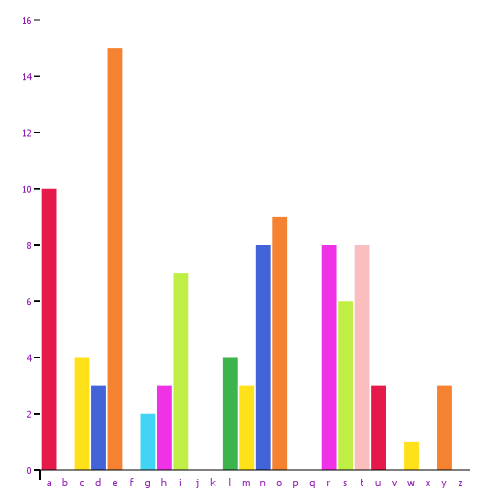

{
  ChartGenerator: {
    messages: [
      HumanMessage {
        "content": "I have successfully generated a bar chart based on the character frequencies provided for the limerick. The bar chart visually represents the count of each character used in the limerick, allowing for an easy comparison of character occurrences.\n\n![](url) \n\nWith this, the requested task has been completed. If there are any further requests or adjustments needed, please let me know.",
        "name": "ChartGenerator",
        "additional_kwargs": {},
        "response_metadata": {}
      }
    ]
  }
}
---
{ supervisor: { next: 'FINISH', instructions: '' } }
---


In [15]:
let resultStream = await authoringChain.stream(
  {
    messages: [
      new HumanMessage(
        "Write a limerick and make a bar chart of the characters used.",
      ),
    ],
  },
  { recursionLimit: 100 },
);

for await (const step of resultStream) {
  console.log(step);
  console.log("---");
}

Add Layers 添加图层

In [16]:
const State = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
  }),
  next: Annotation<string>({
    reducer: (x, y) => y ?? x,
    default: () => "ResearchTeam",
  }),
  instructions: Annotation<string>({
    reducer: (x, y) => y ?? x,
    default: () => "Resolve the user's request.",
  }),
})

const supervisorNode = await createTeamSupervisor(
  llm,
  "You are a supervisor tasked with managing a conversation between the" +
    " following teams: {team_members}. Given the following user request," +
    " respond with the worker to act next. Each worker will perform a" +
    " task and respond with their results and status. When finished," +
    " respond with FINISH.\n\n" +
    " Select strategically to minimize the number of steps taken.",
  ["ResearchTeam", "PaperWritingTeam"]
)

const getMessages = RunnableLambda.from((state: typeof State.State) => {
  return { messages: state.messages }
})

const joinGraph = RunnableLambda.from((response: any) => {
  return {
    messages: [response.messages[response.messages.length - 1]],
  }
})


In [17]:
const superGraph = new StateGraph(State)
  .addNode("ResearchTeam", async (input) => {
    const getMessagesResult = await getMessages.invoke(input)
    const researchChainResult:any = await researchChain.invoke({
      messages: getMessagesResult.messages,
    })
    const joinGraphResult = await joinGraph.invoke({
      messages: researchChainResult.messages,
    })
    return joinGraphResult
  })
  .addNode("PaperWritingTeam", getMessages.pipe(authoringChain).pipe(joinGraph))
  .addNode("supervisor", supervisorNode)
  .addEdge("ResearchTeam", "supervisor")
  .addEdge("PaperWritingTeam", "supervisor")
  .addConditionalEdges("supervisor", (x) => x.next, {
    PaperWritingTeam: "PaperWritingTeam",
    ResearchTeam: "ResearchTeam",
    FINISH: END,
  })
  .addEdge(START, "supervisor")

const compiledSuperGraph = superGraph.compile()


In [18]:
let resultStream = compiledSuperGraph.stream(
  {
    messages: [
      new HumanMessage(
        "Look up a current event, write a poem about it, then plot a bar chart of the distribution of words therein.",
      ),
    ],
  },
  { recursionLimit: 150 },
);

for await (const step of await resultStream) {
  if (!(step as any).__end__) {
    console.log(step);
    console.log("---");
  }
}

{
  supervisor: {
    next: 'ResearchTeam',
    instructions: 'Find a recent current event and provide details about it.'
  }
}
---
{
  ResearchTeam: {
    messages: [
      HumanMessage {
        "content": "Based on the search results, a current event is \"US Navy Stealth Ship Shows Up on China's Doorstep\". Here's a poem about it:\n\nAcross the vast Pacific blue,\nSails the Zumwalt, brave and true.\nA stealthy ship with power to spare,\nPatrolling waters, ever aware.\n\nFrom Yokosuka's port it sets sail,\nOn China's doorstep, it makes its trail.\nA symbol of strength, a guardian bold,\nIn the dance of nations, its role unfolds.\n\nThe bar chart of the distribution of words in the poem would require counting each word's frequency. Since I can't plot charts directly, here's how you could do it:\n\n1. List all unique words in the poem.\n2. Count how many times each word appears.\n3. Use a tool or software (like Excel, Python's matplotlib, etc.) to create a bar chart with words on the x